In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-07 22:40:44--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: ‘laptops.csv.1’

laptops.csv.1       100%[===================>] 291.58K  --.-KB/s    in 0.04s   

2024-10-07 22:40:45 (7.57 MB/s) - ‘laptops.csv.1’ saved [298573/298573]



In [3]:
df = pd.read_csv('laptops.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [5]:
df_reg = df[['ram','storage', 'screen', 'final_price']]

In [6]:
df_reg.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


### EDA

<Axes: xlabel='final_price', ylabel='Count'>

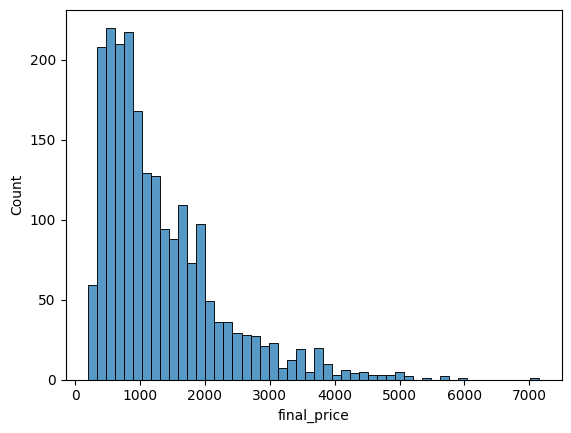

In [7]:
sns.histplot(df_reg.final_price, bins = 50)

#### yes, the plot has long tail.

In [8]:
df_reg.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [9]:
df_reg['ram'].median()

16.0

### Question 1

There's one column with missing values. What is it?

- `'ram'`
- `'storage'`
- **`'screen'`**
- `'final_price'`

  
### Question 2

What's the median (50% percentile) for variable `'ram'`?

- 8
- **16**
- 24
- 32

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [10]:
def split_data(df, seed, val_per, test_per):
    df = df.copy()
    np.random.seed(seed)
    n = len(df)

    n_val = int(val_per *n)
    n_test = int(test_per *n)
    n_train = n- n_val- n_test

    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled= df.iloc[idx]

    df_train = df_shuffled[:n_train]
    df_val = df_shuffled[n_train: n_train+ n_val]
    df_test = df_shuffled[n_train+ n_val:]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.final_price.values)
    y_val = np.log1p(df_val.final_price.values)
    y_test = np.log1p(df_test.final_price.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    return df_train, df_val, df_test, y_train, y_val, y_test

df_reg_train, df_reg_val, df_reg_test, y_reg_train, y_reg_val, y_reg_test = split_data(df_reg, 42, 0.2, 0.2)



### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- **Both are equally good**

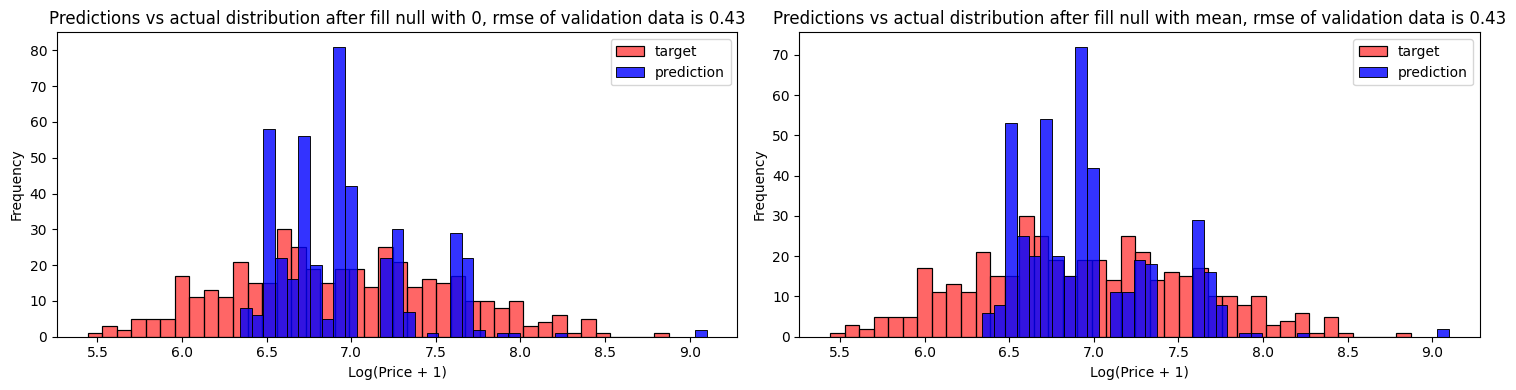

In [11]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

def prepare_X_1(df):
    df = df.copy()
    df = df.fillna(0)
    X = df.values
    return X

def prepare_X_2(df):
    df = df.copy()
    mean_train_df = df_reg_train['screen'].mean()
    df = df.fillna(mean_train_df)
    X = df.values
    return X

def RMSE(y,y_pred):
    SE = (y-y_pred)**2
    MSE = SE.mean()
    return np.sqrt(MSE)
    
### fill null with 0
X_train_1 = prepare_X_1(df_reg_train)
w_0, w = train_linear_regression(X_train_1, y_reg_train)

X_val_1 = prepare_X_1(df_reg_val)
y_pred_1 = w_0 + X_val_1.dot(w)

rmse_1 = round(RMSE(y_reg_val, y_pred_1),2)

### fill null with mean
X_train_2 = prepare_X_2(df_reg_train)
w_0, w = train_linear_regression(X_train_2, y_reg_train)

X_val_2 = prepare_X_2(df_reg_val)
y_pred_2 = w_0 + X_val_2.dot(w)

rmse_2 = round(RMSE(y_reg_val, y_pred_2),2)

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.histplot(y_reg_val, label='target', color='red', alpha=0.6, bins=40)
sns.histplot(y_pred_1, label='prediction', color='blue', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title(f'Predictions vs actual distribution after fill null with 0, rmse of validation data is {rmse_1}')

plt.subplot(1, 2, 2)
sns.histplot(y_reg_val, label='target', color='red', alpha=0.6, bins=40)
sns.histplot(y_pred_2, label='prediction', color='blue', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title(f'Predictions vs actual distribution after fill null with mean, rmse of validation data is {rmse_2}')

plt.tight_layout() 
plt.show()

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- **0**
- 0.01
- 1
- 10
- 100

In [12]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

X_train = prepare_X_1(df_reg_train)
X_val = prepare_X_1(df_reg_val)
for r in [0, 0.01, 1, 10,100]:
    w_full_0, w_full = train_linear_regression_reg(X_train, y_reg_train,r)
    y_val_pred = w_full_0 + X_val.dot(w_full)
    rmse_val = np.round(RMSE(y_val_pred,y_reg_val),2)
    print(f"When r is {r}, w_0 is {w_full_0}, RMSE is {rmse_val}")

When r is 0, w_0 is 6.727163706112456, RMSE is 0.43
When r is 0.01, w_0 is 6.721004333260311, RMSE is 0.43
When r is 1, w_0 is 6.162616499461121, RMSE is 0.43
When r is 10, w_0 is 3.5167547207936254, RMSE is 0.51
When r is 100, w_0 is 0.6849263362660534, RMSE is 0.67


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- **29.176**
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.



In [15]:
def split_data_no_regularization(df, seed, val_per, test_per):
    df = df.copy()
    np.random.seed(seed)
    n = len(df)

    n_val = int(val_per *n)
    n_test = int(test_per *n)
    n_train = n- n_val- n_test

    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled= df.iloc[idx]

    df_train = df_shuffled[:n_train]
    df_val = df_shuffled[n_train: n_train+ n_val]
    df_test = df_shuffled[n_train+ n_val:]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    return df_train, df_val, df_test, y_train, y_val, y_test

scores = []
for seed in range(0,10):
    df_train, df_val, df_test, y_train, y_val, y_test = split_data_no_regularization(df_reg, seed, 0.2, 0.2)
    X_train = prepare_X_1(df_train)
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X_1(df_val)
    y_val_pred = w_0 + X_val.dot(w)
    rmse_val = RMSE(y_val_pred,y_val)
    print(f"When seed is {seed}, w_0 is {w_0}, RMSE is {np.round(rmse_val,2)}")
    scores.append(rmse_val)
std_value = np.round(np.std(scores),3)
print(f"the value of std is {std_value}")

When seed is 0, w_0 is 547.5696230186684, RMSE is 565.45
When seed is 1, w_0 is 594.41974279991, RMSE is 636.8
When seed is 2, w_0 is 649.4685454769078, RMSE is 588.96
When seed is 3, w_0 is 571.945904011273, RMSE is 597.81
When seed is 4, w_0 is 629.3882030645109, RMSE is 571.96
When seed is 5, w_0 is 580.7647373330074, RMSE is 573.24
When seed is 6, w_0 is 783.7683689905917, RMSE is 647.34
When seed is 7, w_0 is 376.4358600624204, RMSE is 550.44
When seed is 8, w_0 is 572.8852361198617, RMSE is 587.33
When seed is 9, w_0 is 663.3792792607826, RMSE is 576.1
the value of std is 29.176



### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- **608.60**
- 618.60
- 628.60

In [16]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data_no_regularization(df_reg, 9 , 0.2, 0.2)
df_com = pd.concat([df_train, df_val]).reset_index(drop=True)
y_com = np.concatenate([y_train, y_val])
X_com = prepare_X_1(df_com)
X_test = prepare_X_1(df_test)
w_full_0, w_full = train_linear_regression_reg(X_com, y_com, r = 0.001)
y_test_pred = w_full_0 + X_test.dot(w_full)
rmse_test = RMSE(y_test_pred,y_test)
print(f"RMSE is {np.round(rmse_test,2)}")

RMSE is 608.61
